# Final Project: Earth Analytics Python Course, Spring 2020
## Steph Shepherd & Lauren Herwehe

Short description of the purpose of the code

In [1]:
# Import libraries
import warnings
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from geopandas import GeoSeries as gs
from shapely.geometry import Point, Polygon
import urllib.request

import contextily as ctx
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from zipfile import ZipFile

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

### Psuedocode
Overlay projected dam locations and rivers (with additional attributes on degree of regulations) on top of protected areas to identify which and to what degree protected areas are impacted by proposed hydropower dams


1. Get Data from figshare download (all are shapefiles)
    * Ramsar Sites
    * Proposed Dams
2. Open each shapefile
    * check CRS
    * select the desired attributes for each shapefile and export to a new geopandas dataframe
    * fill any NA values
3. Select Sites
    * use a buffer of (5 km?, 10 km?, maybe both) to select all Ramsar sites within the buffer distance from a proposed dam
    * save this as a new geopandas dataframe
4. Calculate stats
    * area of land impacted? (from Ramsar site shapefiles)
    * 
4. Create Deliverables - plots/figures
    * Map of all the sites
    * Bar plot Number of sites per region (continent, country, ???)
    * Map of one or two countries/regions
    * Graph comparing these regions.



In [2]:
#Download Data
#Ramsar Sites
urllib.request.urlretrieve("https://ndownloader.figshare.com/articles/12217679/versions/1", "12217679.zip")

with ZipFile('12217679.zip', 'r') as zipObj:
    zipObj.extractall("ramsar")

#Future dams (not a zip file)
et.data.get_data(url="https://ndownloader.figshare.com/files/22486157")

'/home/jovyan/earth-analytics/data/earthpy-downloads/future_dams_2015.csv'

In [3]:
# Open the necessary shapefiles with geopandas
ramsar_areas = gpd.read_file(os.path.join("ramsar", "features_publishedPolygon.shp"))

# Check the crs of the files
print(ramsar_areas.crs)


#Open the cvs file as a geopandas database
fname = os.path.join("earthpy-downloads", "future_dams_2015.csv")
df = pd.read_csv(fname)

# Covert the pandas dataframe to a shapefile for plotting
geometry = [Point(xy) for xy in zip(df.Lon_Cleaned, df.LAT_cleaned)]
crs = {'init': 'epsg:4326'} 
geo_df = gdf(df, crs=crs, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename='proposed_dams.shp')

proposed_dams = gpd.read_file("proposed_dams.shp")


epsg:4326


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
#View information for the dam geodatabase
proposed_dams.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DAM_ID      3700 non-null   int64   
 1   Project na  3700 non-null   object  
 2   Continent   3700 non-null   object  
 3   Country     3700 non-null   object  
 4   Main_river  3670 non-null   object  
 5   Major Basi  3700 non-null   object  
 6   Capacity (  3490 non-null   float64 
 7   LAT_cleane  3700 non-null   float64 
 8   Lon_Cleane  3700 non-null   float64 
 9   Stage       3700 non-null   object  
 10  Start       622 non-null    float64 
 11  End         450 non-null    float64 
 12  Reference   3699 non-null   object  
 13  Referenc_1  370 non-null    object  
 14  Referenc_2  34 non-null     object  
 15  geometry    3700 non-null   geometry
dtypes: float64(5), geometry(1), int64(1), object(9)
memory usage: 462.6+ KB


In [5]:
#Extact the columns needed for analysis
dams_continent = proposed_dams[['Continent', 'Country', 'Stage']]

dams_continent

,Continent,Country,Stage
0,North America,United States,P
1,North America,Canada,P
2,North America,Canada,U
3,North America,Canada,U
4,North America,Canada,P
...,...,...,...
3695,North America,Costa Rica,P
3696,North America,Costa Rica,P
3697,North America,Costa Rica,P
3698,North America,Costa Rica,P


In [6]:
#Group and count data by stage.
dams_stage = dams_continent.groupby(['Continent','Country','Stage'])[['Stage']].count()

dams_stage

Stage
Continent     Country      Stage       
Africa        Angola       P          4
              Benin        P          6
              Burkina Faso P          2
              Burundi      P          2
                           U          1
...                                 ...
South America Guyana       P          3
                           U          1
              Peru         P         37
                           U         10
              Venezuela    P          3

[157 rows x 1 columns]

In [7]:
#Group continent data by stage and count.
cont_stage = dams_continent.groupby(['Continent','Stage'])[['Stage']].count()

cont_stage

Stage
Continent     Stage       
Africa        P        179
              U         21
Asia          P        937
              U        424
Europe        P        611
              U         41
North America P        143
              U         34
Oceania       P          7
              U          1
South America P       1188
              U        114

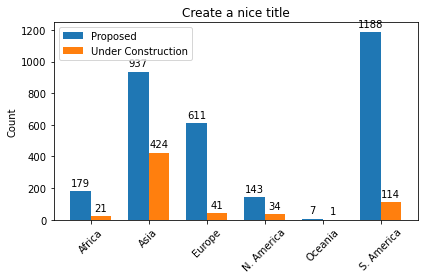

In [8]:
# Create a bar plot of the dams by continent and stage of process.
labels = ['Africa', 'Asia', 'Europe', 'N. America', 'Oceania', 'S. America']
proposed = [179, 937, 611, 143, 7, 1188]
under_const = [21, 424, 41, 34, 1, 114]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, under_const, width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Create a nice title')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its value."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [9]:
# Attempting to select data without resorting to creating lists or numpy arrays
cont_prop = cont_stage[cont_stage.Stage == 'P']

cont_prop

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,,Stage
Continent,Stage,


In [10]:
#Group and count data by stage.
country_stage = dams_continent.groupby(['Continent','Country','Stage'])[['Stage']].count()

country_stage

Stage
Continent     Country      Stage       
Africa        Angola       P          4
              Benin        P          6
              Burkina Faso P          2
              Burundi      P          2
                           U          1
...                                 ...
South America Guyana       P          3
                           U          1
              Peru         P         37
                           U         10
              Venezuela    P          3

[157 rows x 1 columns]

In [19]:
#Extract data by continent.
africa = dams_continent[dams_continent["Continent"] == "Africa"]

#Group and count country data by stage.
africa_stage = africa.groupby(['Country','Stage'])[['Stage']].count()

africa_stage

Stage
Country                  Stage       
Angola                   P          4
Benin                    P          6
Burkina Faso             P          2
Burundi                  P          2
                         U          1
Cameroon                 P          7
                         U          1
Central African Republic P          1
Congo, Rep.              P          8
Côte d'Ivoire            P         12
                         U          1
Egypt, Arab Rep.         P          1
Ethiopia                 P         13
                         U          4
Gabon                    P          1
                         U          1
Ghana                    P         11
                         U          1
Guinea                   P         23
Kenya                    P          6
Lesotho                  P          2
Liberia                  P          7
Malawi                   P          2
Mali                     P         12
                         U          1
Morocco                  U          2
Mozambique               P          3
                         U          1
Namibia                  P          3
Niger                    P          1
                         U          1
Nigeria                  P          1
                         U          2
Rwanda                   U          1
S. Sudan                 P          5
Sierra Leone             P          6
South Africa             P          3
Sudan                    P          3
                         U          1
Tanzania                 P          7
Togo                     P          1
Uganda                   P         15
                         U          1
Zambia                   P          9
                         U          1
Zimbabwe                 P          2
                         U          1

In [20]:
#Extract data by continent.
asia = dams_continent[dams_continent["Continent"] == "Asia"]

#Group and count country data by stage.
asia_stage = asia.groupby(['Country','Stage'])[['Stage']].count()

asia_stage

Stage
Country          Stage       
Afghanistan      P          3
                 U          2
Bangladesh       U          1
Bhutan           P          4
                 U          8
Cambodia         P         13
                 U          2
China            P         97
                 U        141
Georgia          P          5
                 U         15
India            P        109
                 U         72
Indonesia        U          7
Iran             U          7
Japan            U          4
Korea, Dem. Rep. U          1
Kyrgyzstan       P          1
Lao PDR          P         75
                 U          6
Malaysia         P          4
                 U          2
Mongolia         P          1
Myanmar          P         22
                 U          4
Nepal            P        239
                 U         46
Pakistan         P         48
                 U          9
Philippines      U          7
Russia           P          2
Sri Lanka        P          1
                 U          2
Tajikistan       U          1
Turkey           P        310
                 U         36
Uzbekistan       U          1
Vietnam          P          3
                 U         50

In [21]:
#Extract data by continent.
europe = dams_continent[dams_continent["Continent"] == "Europe"]

#Group and count country data by stage.
europe_stage = europe.groupby(['Country','Stage'])[['Stage']].count()

europe_stage

Stage
Country                Stage       
Albania                P         93
                       U          7
Austria                P         22
                       U          3
Belarus                P          2
                       U          5
Bosnia and Herzegovina P        118
                       U          4
Bulgaria               P         42
                       U          7
Croatia                P         80
                       U          1
France                 P          1
Greece                 P          4
                       U          2
Hungary                P          1
Iceland                P          3
                       U          1
Kosovo                 P         23
Macedonia              P         22
                       U          1
Montenegro             P         83
Poland                 P          1
Portugal               P          7
                       U          3
Romania                P          1
                       U          1
Russia                 P          8
                       U          3
Serbia                 P         59
Slovenia               P         41
                       U          1
Spain                  U          1
United Kingdom         U          1

In [22]:
#Extract data by continent.
n_america = dams_continent[dams_continent["Continent"] == "North America"]

#Group and count country data by stage.
n_america_stage = n_america.groupby(['Country','Stage'])[['Stage']].count()

n_america_stage

Stage
Country       Stage       
Belize        P          1
Canada        P         26
              U          8
Costa Rica    P         40
              U          3
El Salvador   P          1
Guatemala     U          2
Haiti         P          1
Honduras      U          2
Mexico        P          4
              U          3
Nicaragua     P         17
              U          1
Panama        P         43
              U         15
United States P         10

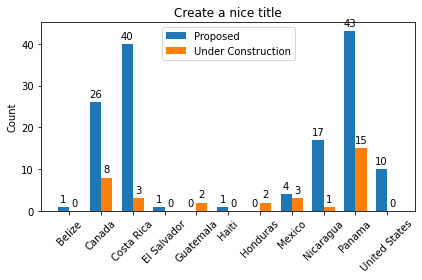

In [31]:
# Create a bar plot of the dams by continent and stage of process.
na_labels = ['Belize', 'Canada', 'Costa Rica', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'United States']
na_proposed = [1, 26, 40, 1, 0, 1, 0, 4, 17, 43, 10]
na_under_const = [0, 8, 3, 0, 2, 0, 2, 3, 1, 15, 0]

x = np.arange(len(na_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, na_proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, na_under_const, width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Create a nice title')
ax.set_xticks(x)
ax.set_xticklabels(na_labels, rotation=45)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its value."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [23]:
#Extract data by continent.
oceania = dams_continent[dams_continent["Continent"] == "Oceania"]

#Group and count country data by stage.
oceania_stage = oceania.groupby(['Country','Stage'])[['Stage']].count()

oceania_stage

Stage
Country          Stage       
New Zealand      P          6
Papua New Guinea P          1
                 U          1

In [25]:
#Extract data by continent.
s_america = dams_continent[dams_continent["Continent"] == "South America"]

#Group and count country data by stage.
s_america_stage = s_america.groupby(['Country','Stage'])[['Stage']].count()

s_america_stage

Stage
Country        Stage       
Argentina      P         68
               U          2
Bolivia        P         22
               U          2
Brazil         P        954
               U         73
Chile          P         19
               U          9
Colombia       P         25
               U          5
Dominican Rep. U          2
Ecuador        P         57
               U         10
Guyana         P          3
               U          1
Peru           P         37
               U         10
Venezuela      P          3

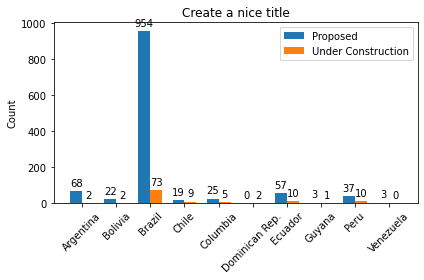

In [29]:
# Create a bar plot of the dams by continent and stage of process.
sa_labels = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Columbia', 'Dominican Rep.', 'Ecuador', 'Guyana', 'Peru', 'Venezuela']
sa_proposed = [68, 22, 954, 19, 25, 0, 57, 3, 37, 3]
sa_under_const = [2, 2, 73, 9, 5, 2, 10, 1, 10, 0]

x = np.arange(len(sa_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sa_proposed, width, label='Proposed')
rects2 = ax.bar(x + width/2, sa_under_const, width, label='Under Construction')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Create a nice title')
ax.set_xticks(x)
ax.set_xticklabels(sa_labels, rotation=45)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its value."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()